# **pLitter - Identifying Plastic Litter using Vision and AI**

<table align="left"><td>
  <a target="_blank"  href="https://github.com/gicait/pLitter/blob/main/docs/notebooks/pLitter_demo.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on github
  </a>
</td><td>
  <a target="_blank"  href="https://colab.sandbox.google.com/github/gicait/pLitter/blob/main/docs/notebooks/pLitter_demo.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td></table>
<hr>



pLitter is a simple tool to predict the plastic litter from streets and visualize with heatmaps to analyse the littering hotspots and plastic leakage.

Contents:

    1) Frame Exraction from Video
    2) Inference (detecting plastic litter)
    3) Heatmap Generation



In [ ]:
# clone pLitter repositopry
!rm -rf pLitter/
!git clone https://github.com/gicait/pLitter.git

In [ ]:
# instll dependencies
!pip install piexif

!pip uninstall -y opencv-python-headless opencv-contrib-python
# !apt install python3-opencv  # the one pre-installed have some issues with video writing

#for visualization
!git clone https://github.com/google/automl.git
# !cp -r automl/efficientdet/visualize pLitter/scripts/code/
!cp -r automl/efficientdet/visualize /content/pLitter/tools/py

###**1) Frame Exraction from Video** 

If the video is recorded with GoPro, its encoding is not supported with OpenCV. Option is to use ffmpeg tool to change encoding.

In [4]:
import os
from pLitter.tools.py.makeImages import Video

In [6]:
# download a sample video from https://drive.google.com/file/d/1g5f1eL7iRRW1I99mJwV8ah_le9RH9aY0/view?usp=sharing
# ignore downloading and modify path in the below cells, if you already have a video and gps data in csv file

!mkdir data
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1g5f1eL7iRRW1I99mJwV8ah_le9RH9aY0' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1g5f1eL7iRRW1I99mJwV8ah_le9RH9aY0" -O data/sample.zip && rm -rf /tmp/cookies.txt
!unzip data/sample.zip -d data/.
!rm -rf '/content/data/sample.zip'

--2021-05-25 04:11:02--  https://docs.google.com/uc?export=download&confirm=OEJT&id=1g5f1eL7iRRW1I99mJwV8ah_le9RH9aY0
Resolving docs.google.com (docs.google.com)... 74.125.197.113, 74.125.197.138, 74.125.197.101, ...
Connecting to docs.google.com (docs.google.com)|74.125.197.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-70-docs.googleusercontent.com/docs/securesc/l5udtkm2h661lga1it4flo3qta4a5enh/hprbc85k5hakablrl8ruh5kqbn5u46sg/1621915800000/10915217646116291607/09252209777815652098Z/1g5f1eL7iRRW1I99mJwV8ah_le9RH9aY0?e=download [following]
--2021-05-25 04:11:02--  https://doc-0s-70-docs.googleusercontent.com/docs/securesc/l5udtkm2h661lga1it4flo3qta4a5enh/hprbc85k5hakablrl8ruh5kqbn5u46sg/1621915800000/10915217646116291607/09252209777815652098Z/1g5f1eL7iRRW1I99mJwV8ah_le9RH9aY0?e=download
Resolving doc-0s-70-docs.googleusercontent.com (doc-0s-70-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting

In [ ]:
# # Install dependencies, download the video, and crop 5 seconds for processing
# !pip install youtube-dl
# !youtube-dl https://www.youtube.com/watch?v=ll8TgCZ0plk -f 22 -o video.mp4

In [ ]:
# it will run for few minutes 

vid = Video(file_name = "/content/data/sample_video.mp4", gps_file = "/content/data/sample_GPS5.csv")
vid.byGps(out_path='data')

###**2) Inference (detecting plastic litter)**

To make predictions,

Two options,

1. Run model locally
2. Predict from AutoML cloud API

In [28]:
import sys
sys.path.append("/content/pLitter/tools/py")
from pLitter.tools.py.inference import inference
from pLitter.tools.py.utils import draw_bounding_box_on_image
from PIL import Image
import cv2
from automl.efficientdet.visualize.vis_utils import visualize_boxes_and_labels_on_image_array as vis
from google.colab.patches import cv2_imshow

inf = inference()

Following example shows prediction using the exported model, which runs locally

In [29]:
"""
  Have to load "saved_model.pb" from models/ to inference locally 
"""
inf.load_local_model("/content/pLitter/models/automl/")

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [30]:
pred = inf.predict_from_local('/content/data/sample_video/sample_video_10.jpg')
classes = pred['detection_classes'].numpy()[0]
classes = classes.astype('int32')
scores = pred['detection_multiclass_scores'].numpy()[0][:,1]
boxes = pred['detection_boxes'].numpy()[0]
category_index = {1: {'id': 1, 'name': 'pL'}}

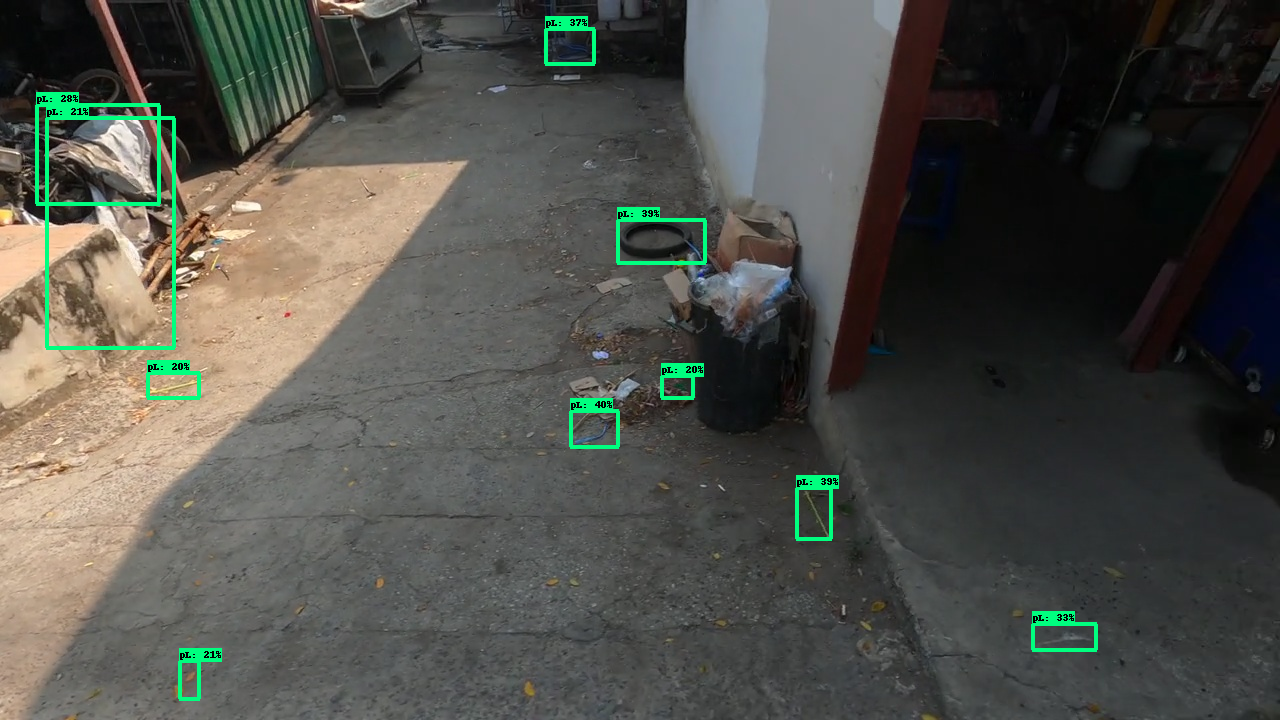

In [31]:
image = cv2.imread('/content/data/sample_video/sample_video_10.jpg')
res = vis(image=image, boxes=boxes, classes=classes, scores=scores, use_normalized_coordinates=True, min_score_thresh=.2, category_index=category_index)
cv2_imshow(res)

Following example fetches predictions from AutoML cloud API

In [ ]:
"""
  it will fetch inferences from cloud hosted model
  throws error if cloud host is not available
"""
preds = inf.predict_from_cloud('/content/data/sample_video/sample_video_10.jpg') 
# preds

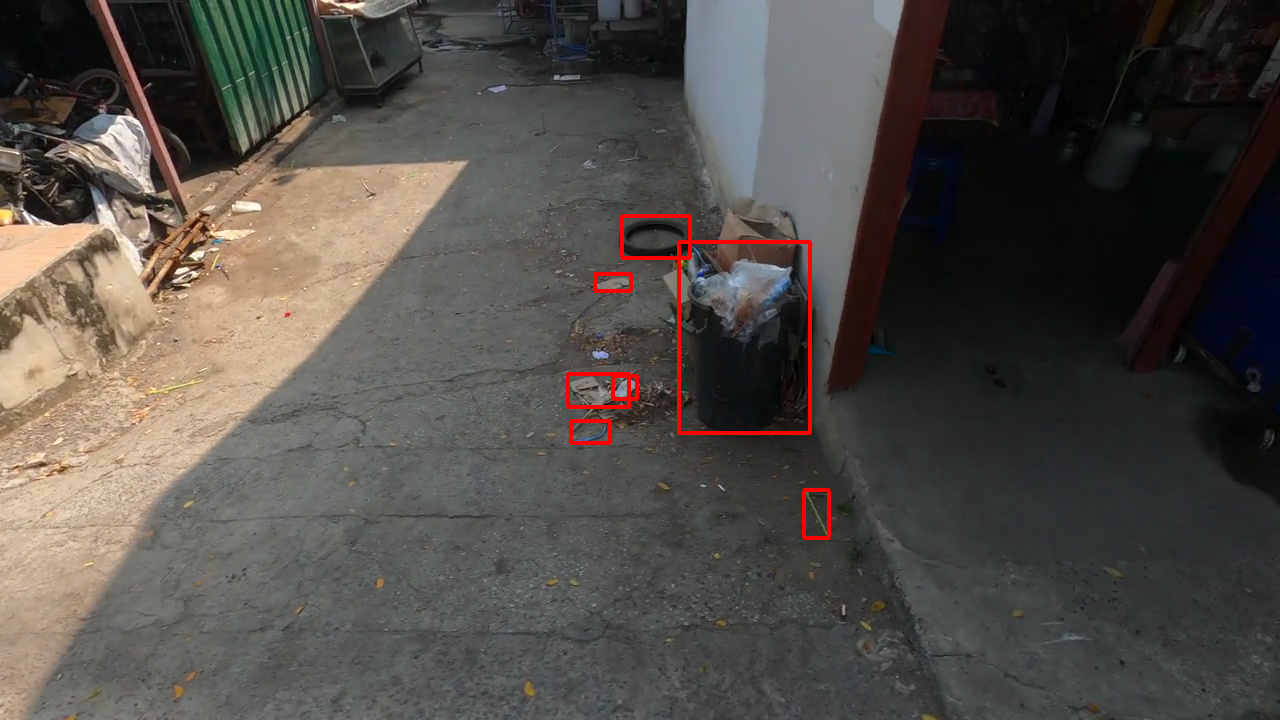

In [ ]:
image_pil = Image.open('/content/pLitter/data/sample_video/sample_video_10.jpg')
for pred in preds:
  xmin, ymin = pred[0][0], pred[0][1]
  xmax, ymax = pred[1][0], pred[1][1]
  draw_bounding_box_on_image(image_pil, ymin, xmin, ymax, xmax)

from IPython.display import display
display(image_pil)

Example of making predictions in loop and storing the object count a csv file for heatmap visualization

In [35]:
import csv

# predict in loop for all images
with open("/content/data/sample_video/sample_video.csv") as f:
  reader = csv.reader(f)
  for row in reader:
    pred = inf.predict_from_local('/content/data/sample_video/'+row[0])
    classes = pred['detection_classes'].numpy()[0]
    classes = classes.astype('int32')
    scores = pred['detection_multiclass_scores'].numpy()[0][:,1]
    boxes = pred['detection_boxes'].numpy()[0]
    with open("/content/data/sample_video/"+row[0].split('.')[0]+".csv", 'w') as cf:
      writer = csv.writer(cf)
      for i in range(len(boxes)):
        wrow = [classes[i], scores[i], boxes[i]]
        writer.writerow(wrow)
    cf.close()
f.close()

###**3) Heatmap genration**

The following heatmap generation is based on information including, 

1. number of plastic objects detected, and
2. GPS Location of that image (exif metadata, [lat,lon])


To heatmap a street,
If you have set a geo-tagged images, continue.. next!

or!

If you a video, you need to conevrt into frmaes with including geo-tag.
For GoPro collected videos, check out <a> https://goprotelemetryextractor.com/free/#</a>, upload video and download gps info in CSV format., 

Use the "Video.byGps()" to cut into frames, predict, and save to csv file or to a list variable.


In [36]:
import folium
from folium import plugins
from folium.plugins import HeatMap

In [37]:
# display each image locaton with marker
# import csv

icon_circle = folium.plugins.BeautifyIcon(
    icon_shape='circle-dot', 
    border_color='green', 
    border_width=10,
)

head = 1
with open("/content/data/sample_video/sample_video.csv") as f:
  reader = csv.reader(f)
  for row in reader:
    if head == 1:
      head = 0
      rangsit_map = folium.Map(location=[float(row[1]), float(row[2])], zoom_start = 18)
    tooltip = row[0]
    # folium.CircleMarker(location = [row['Latitude'],row['Longitude']], radius=500, popup="Station: " + row['stations'], color='#0000FF', fill_color='#0000FF').add_to(m)
    folium.CircleMarker([float(row[1]), float(row[2])], radius=.1, popup="<i>"+row[0]+"</i>", tooltip=tooltip, icon=icon_circle).add_to(rangsit_map)

rangsit_map


# googleSat = L.tileLayer('http://{s}.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',{
    # maxZoom: 20,
    # subdomains:['mt0','mt1','mt2','mt3']
# });


In [38]:
min_score_thresh = 0.2
heat_data = []
max_count = 0

rangsit_map = folium.Map(location=[float(row[1]), float(row[2])], zoom_start = 18)

with open("/content/data/sample_video/sample_video.csv") as f:
  reader = csv.reader(f)
  for row in reader:
    with open("/content/data/sample_video/"+row[0].split('.')[0]+".csv", 'r') as cf:
      creader = csv.reader(cf)
      count = 0
      for crow in  creader:
        if float(crow[1]) >= min_score_thresh:
          count += 1
      heat_data.append([float(row[1]), float(row[2]), count])
      if count > max_count:
        max_count = count
# 
# 
# need to play with it for better heatmap vis
print(max_count)

HeatMap(heat_data, radius = 10, min_opacity = 0.1, max_val = max_count,gradient={.1: 'yellow', .5: 'red', .9: 'blue'}).add_to(rangsit_map)
rangsit_map

22


In [ ]:
# heat_data = [[item[0], item[1]] for item in hm]
# HeatMap(hm, radius = 20, min_opacity = 0.1, max_val = 50,gradient={.2: 'blue', .3: 'lime', .4: 'red'}).add_to(talad_map)
# talad_map

In [ ]:
# m = folium.Map((0.5, 0.5), zoom_start=8, tiles=None)
# HeatMap(
# # make five dots with different weights: 1, 2, 3, 4 and 5
# data=[(0  , 0, 0.1),
#       (0.5, 0, 0.2),
#       (1.0, 0, 0.3),
#       (1.5, 0, 0.4),
#       (2.0, 0, 0.5)] , radius=25, blur = 10, min_opacity = 0, max_val = 0.0005).add_to(m)
# m

Inference on videos


In [45]:
# inf.video_inference 

import cv2
import tqdm

def run_on_video(video):
    while True:
        ret, frame = video.read()
        if ret:
          pred = inf.predict_from_local(frame)
          classes = pred['detection_classes'].numpy()[0]
          classes = classes.astype('int32')
          scores = pred['detection_multiclass_scores'].numpy()[0][:,1]
          boxes = pred['detection_boxes'].numpy()[0]
          category_index = {1: {'id': 1, 'name': 'pL'}}
          res = vis(image=frame, boxes=boxes, classes=classes, scores=scores, use_normalized_coordinates=True, min_score_thresh=.2, category_index=category_index)
          yield res
        else:
          break

In [ ]:
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('/content/data/sample_video_output.avi', fourcc, 59.94, (848,  480))
cap = cv2.VideoCapture("/content/data/sample_video.mp4")
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# run_on_video(cap)
for vis_frame in tqdm.tqdm(run_on_video(cap), total=num_frames):
    out.write(vis_frame)
cap.release()
out.release()